## Introduction

On se lance dans le projet *N-body*. Il est conseillé d'utiliser C++, et c'est effectivement ce que nous allons faire. Néanmoins, pour des raisons pratiques, tous les plots seront faits en Python au travers de fichiers .txt.

Sans plus attendre, on va pouvoir se lancer dans les premières tâches du projet!

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
from fancy_package import *

plt.style.use("ggplot")


___

## 1. First Task

On reste tranquillement en Python !

### 1.1. Première étape

* [X] Vérifier la forme de la fonction de densité $\rho(r)$. Comparer à la densité décrite dans le papier.
* [X] Check les choix d'unités, une fois que l'on a fixé G = 1.

La première étape est simplement de jeter un oeil au fichier `data.txt`.

In [2]:
with open("../files/data.txt", 'r') as f:
    data = []
    lines = f.readlines()
    for line in lines:
        numbers = [float(x.strip()) for x in line.split() if x.strip()]
        data.extend(numbers[1:]) # first is index => we don't care
    columns = ["m", "x", "y", "z", "vx", "vy", "vz", "eps", "phi"] # last two are sftening and potential => we actually don't care
    df = pd.DataFrame(np.array(data).reshape(-1, len(columns)), columns=columns)

df.head(3)    

,m,x,y,z,vx,vy,vz,eps,phi
0,92.4259,-0.003816,-0.079670,-0.019072,3779.62,354.734,-73.45010,0.1,0.013022
1,92.4259,-0.032298,-0.249461,-0.010890,3250.59,-674.280,-18.33470,0.1,0.013022
2,92.4259,0.067577,-0.810356,-0.006849,2190.86,199.053,3.86061,0.1,0.013022


Dans (Hernquist et al.)[files/Hernquist_et_al.pdf], on trouve la densité de masse :
$$
\rho(r) = \frac{M}{2\pi} \frac{a}{r} \frac{1}{(r+a)^3}
$$
avec $M$ la masse totale et $a$ une échelle de distance charactéristique (qu'on va fit!). La distribution de masse cumulative (la masse entre $r$ et $r+dr$) est donc:

\begin{align*}
    M(R) &= \int_0^R 4 \pi r^2 \rho(r) dr \\
         &= 2M \int_0^R \frac{ar}{(r+a)^3} dr \\
         &= 2M \int_a^{a+R} \frac{a(u-a)}{u^3}du  \ \ \ (u = r + a) \\
         &= 2M \int_a^{a+R} \left( \frac{a}{u^2} - \frac{a^2}{u^3} \right) du\\
         &= 2M \left( \left[ -\frac{a}{u} \right]_a^{a+R} + \left[ \frac{a^2}{2u^2} \right]_a^{a+R} \right) \\
         &= 2M \left(
            1 - \frac{a}{a+R} + \frac{a^2}{2 (R+a)^2} - \frac{1}{2}
         \right)\\
         &= 2M \frac{1}{(R+a)^2} \left(
            \frac{1}{2}(R+a)^2 - a(R+a) + \frac{a^2}{2}
         \right)\\
         &= M \frac{R^2}{(R+a)^2}
\end{align*}

Voilà qui a une bonne tête ! Avec cette masse cumulative, on va pouvoir utiliser l'équivalent de la **loi de Gauss** pour un champ gravitationnel:
$$
\oint_{r=R} \vec{g} \cdot d\vec{S} = -4 \pi G M(R)
$$

Avec la symétrie centrale, on obtient:
$$
g_r 4 \pi R^2 = -4\pi \frac{GMR^2}{(R+a)^2} 
$$
et ainsi
$$
g_r = - \frac{GM}{(R+a)^2}
$$
qu'on intègre afin d'obtenir le potentiel gravitationnel:
$$
\phi(r) = \frac{GM}{(R+a)}
$$

Mais trêve de blabla, jettons un peu un oeil à nos données !

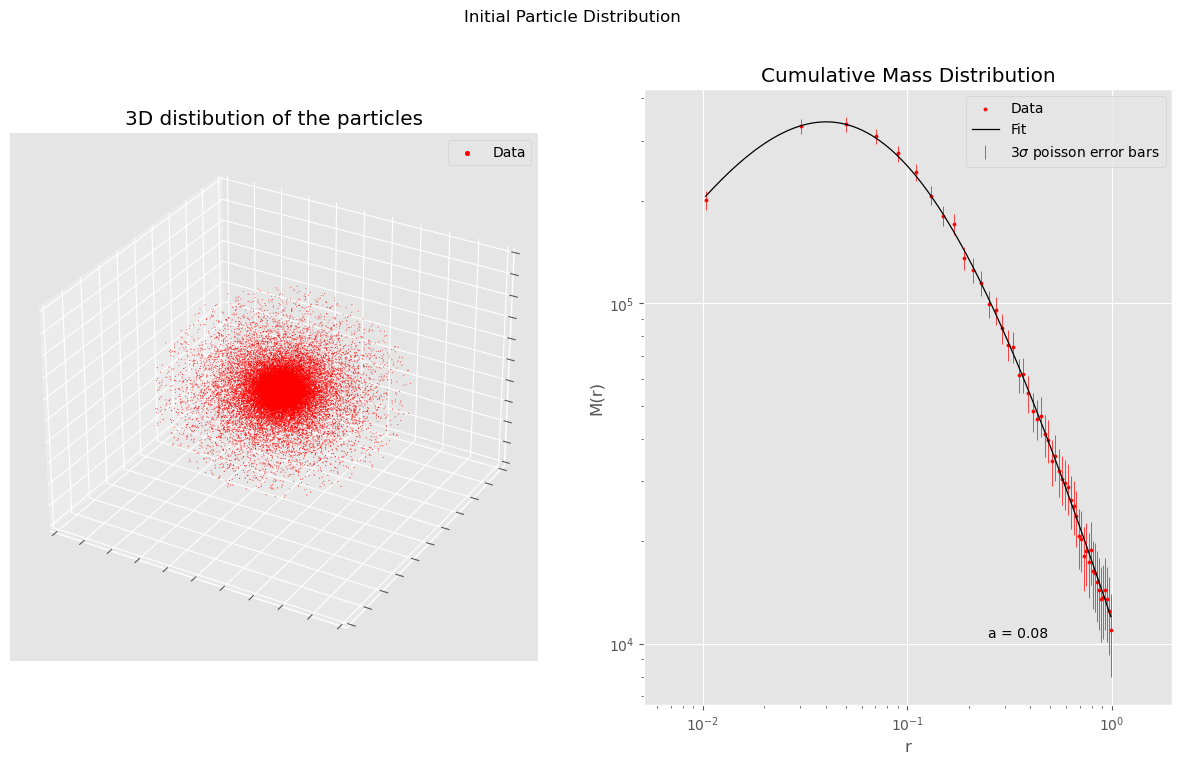

In [14]:
NBINS = 50

df["r"] = np.sqrt(df["x"]**2 + df["y"]**2 + df["z"]**2)
df_to_plot = df[df["r"]<1]

#3d scatter of the data
plt.figure(figsize=(15, 8))
plt.suptitle("Initial Particle Distribution")
grid = GridSpec(1, 2, hspace=1)
plt.subplot(grid[0], projection="3d")
plt.title("3D distibution of the particles")
plt.gca().scatter(df_to_plot["x"], df_to_plot["y"], df_to_plot["z"], color='red', s=0.1)
plt.gca().scatter([],[],[], label="Data", color='red', s=10)
plt.legend()
plt.xticks(plt.xticks()[0], [])
plt.yticks(plt.yticks()[0], [])
plt.gca().set_zticks(plt.gca().get_zticks(), [])

plt.subplot(grid[1])

# we need this data if we want to do a fit
hist, bin_edges = np.histogram(df_to_plot["r"], bins=NBINS, weights=df_to_plot["m"])
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2


M = df["m"].sum()
def rho(r, a):
    rho_r = M / (2*np.pi) * (a/r) * 1/((r+a)**3)
    return rho_r * 4*np.pi*r**2 * 1/NBINS

x = np.linspace(min(bin_centers), max(bin_centers), 1000)
a, _ = curve_fit(rho, bin_centers, hist)
a = a[0]

# count the number of particles in each bin

plt.title("Cumulative Mass Distribution")


plt.scatter(bin_centers, hist, color='red', s=5, label="Data")

errors = np.sqrt(hist / (M/len(df))) * M/len(df) * 3 # sigma = sqrt(N)
plt.errorbar(bin_centers, hist, yerr=errors, fmt='none', color='red', elinewidth=0.5, label = "$3\sigma$ poisson error bars") # we don't see a thing...

plt.plot(x, rho(x, a), label="Fit", color='black', linewidth=0.9)
#errors = np.sqrt(rho(x, a))*5
#plt.fill_between(x, rho(x, a)-errors, rho(x, a)+errors, alpha=0.3, color='black')
plt.text(0.65, 0.11, f"a = {a:.2f}", transform=plt.gca().transAxes)

plt.xlabel("r")
plt.ylabel("M(r)")
plt.xlim(np.min(x)/2, np.max(x)*2)

plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()

Voilà qui est fait ! Maintenant, parlons un peu des unités. En gros, si on veut simuler des galaxies, les grandeurs de masse et de distance sont à peu près fixées:

\begin{align*}
M_{tot} &= 10^{10} M_{\odot}\\
R &= 40 kpc
\end{align*}

Là on ne se pose pas vraiment de question. L'inconnue c'est plutôt le pas de temps. En effet, si on utilise $G \approx 10^{-11}$, on va devoir attendre des milliards d'années pour voir la galaxie évoluer. On décide plutôt de fixer $G=1$. La dimension du temps sera alors bien plus raisonnable, ce qu'on constate après une simple analyse dimensionnelle. On se rappelle de la formule de la *typical particle velocity*:

$$
v = \sqrt{\frac{GM_{tot}}{R}}
$$

Le temps caractéristique de collision de deux particules était alors $t_{cross} = \frac{R}{v} = \frac{R^{3/2}}{\sqrt{GM_{tot}}}$ (pour rappel, le temps de relaxation est proportionnel à $t_{cross}$ et au nombre de particules). En fixant G=1, on choisit d'exprimer le temps caractéristique :

$$
t_{cross} = \sqrt{\frac{R^3}{M_{tot}}}
$$

Mais bon en vrai je comprends pas trop ce qu'on est censé dire à partir de là...

### 1.2. Deuxième Étape

* [ ] Calculer les forces appliquées à chaque particule de manière directe (avec $\epsilon$). Tester pour différentes valeurs de $\epsilon$.
* [ ] Comparer des calculs directs de forces à la solution exacte donnée par le livre *Galactic Dynamics* (aussi appelée **loi de Gauss** cf ci-dessus, on a déjà la valeur de la Force).
* [ ] Calculer le temps de relaxation du system et commenter le lien avec $\epsilon$.

Pour ça, on va avoir besoin d'un calcul direct des forces. Le script en Python part pour 44h (à cause de `iterrows` je crois, en vrai ça doit pas être si long que ça), donc ça ne va pas le faire. On va préférer créer un programme en C++ qui exportera le résultat dans un fichier.